# DC-TSS Example with PAMAP2 

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import os
import csv
from scipy import stats as st
from utils import *

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets


import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torch.autograd import Variable
import math
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance
from TS_DEC import *
#from TS_DEC_Linear import *


from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine as cosine_distance
from typing import Optional, List
from scipy.io import arff

from scipy.signal import find_peaks, peak_prominences


import warnings
warnings.filterwarnings("ignore")

## Set Parameters

In [2]:
# Hyper parameters for Neural Network
epochs1 = 1200
epochs2 = 8000
lr=0.1
pre_lr = 1.5e-3
layers = [10,8,8,3]
strides = [3,3,3,3]
batch_size = 1500

# DC-TSS hyper-parameters
window_length = 160
overlap_percent = 0.2
n_clusters = 60
window_length2 = 50



## Read Dataset

In [3]:
#selected_songs = [2,140,30056,30058,85594,120308,120194,120112,120105]
time_series = np.loadtxt("./data/PAMAP2.csv", delimiter=",")
labels = np.loadtxt("./data/PAMAP2_labels.csv", delimiter=",")
ground_truth = np.where(labels[:-1] != labels[1:])[0]


## Subsequence TS

In [5]:
start = 0
subsequences = []
subsequence_labels = []

while start+window_length < len(time_series[0]):
    subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])    
    subsequence = time_series[:,start:start+window_length]
    start = start+window_length - int(overlap_percent*window_length)
    subsequences.append(subsequence)
    subsequences.append(np.roll(subsequence, -(window_length)//4))
    subsequences.append(np.roll(subsequence, (window_length)//4))
    subsequences.append(np.roll(subsequence, (window_length)//2))

subsequences = np.asarray(subsequences)
subsequence_labels = np.asarray(subsequence_labels)

In [6]:
subsequences.shape

(11760, 40, 160)

## Set Data_loader for Neural Network

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


data_loader = get_dataloader(data=subsequences,
                          shuffle=False,
                          batch_size=batch_size,
                          data_transforms=None)
torch.cuda.empty_cache()
input_shape = subsequences.shape
#torch.cuda.memory_summary(device=None, abbreviated=False)



cuda


## Create DC-TSS model

In [7]:
deep_cluster_model = DEC(n_clusters = n_clusters, input_shape=input_shape,k_sizes=layers,strides=strides)
deep_cluster_model.to(device)


DEC(
  (AE): Autoencoder(
    (encoder): Sequential(
      (0): Conv1d(40, 40, kernel_size=(10,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv1d(40, 40, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Conv1d(40, 40, kernel_size=(8,), stride=(3,))
      (5): LeakyReLU(negative_slope=0.1)
      (6): Conv1d(40, 40, kernel_size=(3,), stride=(3,))
    )
    (decoder): Sequential(
      (0): ConvTranspose1d(40, 40, kernel_size=(3,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): ConvTranspose1d(40, 40, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): ConvTranspose1d(40, 40, kernel_size=(8,), stride=(3,))
      (5): LeakyReLU(negative_slope=0.1)
      (6): ConvTranspose1d(40, 40, kernel_size=(10,), stride=(3,))
      (7): LeakyReLU(negative_slope=0.1)
      (8): Upsample(size=160, mode=nearest)
    )
  )
  (clustlayer): clustering()
  (model): Sequential(
    (0): Sequential(
      

## Phase 1: Initialize Latent Space Mapping with 1DCNN AE

In [8]:
pretraining(model=deep_cluster_model, dbgenerator=data_loader, batch_size=batch_size, epochs=epochs1,lr=pre_lr)


epoch 1,loss = 0.99895686
epoch 2,loss = 0.99886918
epoch 3,loss = 0.99879813
epoch 4,loss = 0.99872756
epoch 5,loss = 0.99862695
epoch 6,loss = 0.99841654
epoch 7,loss = 0.99790347
epoch 8,loss = 0.99661946
epoch 9,loss = 0.99373728
epoch 10,loss = 0.98781389
epoch 11,loss = 0.97733080
epoch 12,loss = 0.96588498
epoch 13,loss = 0.97363871
epoch 14,loss = 0.95921683
epoch 15,loss = 0.95212734
epoch 16,loss = 0.95158821
epoch 17,loss = 0.95134377
epoch 18,loss = 0.94845432
epoch 19,loss = 0.94317007
epoch 20,loss = 0.93839848
epoch 21,loss = 0.93747681
epoch 22,loss = 0.93721831
epoch 23,loss = 0.93288416
epoch 24,loss = 0.92925274
epoch 25,loss = 0.92774844
epoch 26,loss = 0.92626321
epoch 27,loss = 0.92429996
epoch 28,loss = 0.92099947
epoch 29,loss = 0.91778272
epoch 30,loss = 0.91627359
epoch 31,loss = 0.91359001
epoch 32,loss = 0.90939254
epoch 33,loss = 0.90627211
epoch 34,loss = 0.90416038
epoch 35,loss = 0.90123171
epoch 36,loss = 0.89815712
epoch 37,loss = 0.89638817
epoch 38,l

epoch 298,loss = 0.53864521
epoch 299,loss = 0.53909940
epoch 300,loss = 0.53979552
epoch 301,loss = 0.53947705
epoch 302,loss = 0.53760064
epoch 303,loss = 0.53482550
epoch 304,loss = 0.53470367
epoch 305,loss = 0.53579366
epoch 306,loss = 0.53487891
epoch 307,loss = 0.53276497
epoch 308,loss = 0.53234738
epoch 309,loss = 0.53293389
epoch 310,loss = 0.53226411
epoch 311,loss = 0.53077245
epoch 312,loss = 0.53025228
epoch 313,loss = 0.53026325
epoch 314,loss = 0.52972364
epoch 315,loss = 0.52863723
epoch 316,loss = 0.52808428
epoch 317,loss = 0.52776754
epoch 318,loss = 0.52745652
epoch 319,loss = 0.52673090
epoch 320,loss = 0.52593440
epoch 321,loss = 0.52541059
epoch 322,loss = 0.52530122
epoch 323,loss = 0.52488106
epoch 324,loss = 0.52398580
epoch 325,loss = 0.52322811
epoch 326,loss = 0.52297145
epoch 327,loss = 0.52270734
epoch 328,loss = 0.52225530
epoch 329,loss = 0.52155519
epoch 330,loss = 0.52089655
epoch 331,loss = 0.52049434
epoch 332,loss = 0.52028853
epoch 333,loss = 0.5

epoch 591,loss = 0.45406586
epoch 592,loss = 0.45377329
epoch 593,loss = 0.45351094
epoch 594,loss = 0.45354497
epoch 595,loss = 0.45354608
epoch 596,loss = 0.45318893
epoch 597,loss = 0.45267218
epoch 598,loss = 0.45246175
epoch 599,loss = 0.45265147
epoch 600,loss = 0.45282963
epoch 601,loss = 0.45265433
epoch 602,loss = 0.45257100
epoch 603,loss = 0.45286053
epoch 604,loss = 0.45396757
epoch 605,loss = 0.45497504
epoch 606,loss = 0.45467761
epoch 607,loss = 0.45283452
epoch 608,loss = 0.45162639
epoch 609,loss = 0.45146206
epoch 610,loss = 0.45212555
epoch 611,loss = 0.45270494
epoch 612,loss = 0.45201084
epoch 613,loss = 0.45104825
epoch 614,loss = 0.45061311
epoch 615,loss = 0.45086884
epoch 616,loss = 0.45124310
epoch 617,loss = 0.45077896
epoch 618,loss = 0.45006305
epoch 619,loss = 0.44970727
epoch 620,loss = 0.45005548
epoch 621,loss = 0.45047450
epoch 622,loss = 0.45026642
epoch 623,loss = 0.45008472
epoch 624,loss = 0.45057324
epoch 625,loss = 0.45202842
epoch 626,loss = 0.4

epoch 884,loss = 0.42365456
epoch 885,loss = 0.42339876
epoch 886,loss = 0.42330143
epoch 887,loss = 0.42318156
epoch 888,loss = 0.42272723
epoch 889,loss = 0.42263395
epoch 890,loss = 0.42292434
epoch 891,loss = 0.42313972
epoch 892,loss = 0.42292872
epoch 893,loss = 0.42264795
epoch 894,loss = 0.42289960
epoch 895,loss = 0.42373967
epoch 896,loss = 0.42385215
epoch 897,loss = 0.42364758
epoch 898,loss = 0.42285612
epoch 899,loss = 0.42243579
epoch 900,loss = 0.42194113
epoch 901,loss = 0.42162409
epoch 902,loss = 0.42151120
epoch 903,loss = 0.42164880
epoch 904,loss = 0.42190024
epoch 905,loss = 0.42182022
epoch 906,loss = 0.42190778
epoch 907,loss = 0.42184132
epoch 908,loss = 0.42181018
epoch 909,loss = 0.42137548
epoch 910,loss = 0.42102709
epoch 911,loss = 0.42102835
epoch 912,loss = 0.42164731
epoch 913,loss = 0.42223540
epoch 914,loss = 0.42284381
epoch 915,loss = 0.42274815
epoch 916,loss = 0.42219239
epoch 917,loss = 0.42118749
epoch 918,loss = 0.42064539
epoch 919,loss = 0.4

epoch 1171,loss = 0.40462807
epoch 1172,loss = 0.40477052
epoch 1173,loss = 0.40494272
epoch 1174,loss = 0.40479168
epoch 1175,loss = 0.40454486
epoch 1176,loss = 0.40438491
epoch 1177,loss = 0.40440759
epoch 1178,loss = 0.40477943
epoch 1179,loss = 0.40498593
epoch 1180,loss = 0.40513739
epoch 1181,loss = 0.40507403
epoch 1182,loss = 0.40530154
epoch 1183,loss = 0.40551096
epoch 1184,loss = 0.40575916
epoch 1185,loss = 0.40542656
epoch 1186,loss = 0.40484190
epoch 1187,loss = 0.40431282
epoch 1188,loss = 0.40419644
epoch 1189,loss = 0.40472785
epoch 1190,loss = 0.40505373
epoch 1191,loss = 0.40515360
epoch 1192,loss = 0.40466359
epoch 1193,loss = 0.40420040
epoch 1194,loss = 0.40406653
epoch 1195,loss = 0.40421715
epoch 1196,loss = 0.40477690
epoch 1197,loss = 0.40518412
epoch 1198,loss = 0.40647069
epoch 1199,loss = 0.40596598
epoch 1200,loss = 0.40534684


In [9]:
torch.save(deep_cluster_model.state_dict(), './PAMAP2_pretrain.pth')

In [8]:
deep_cluster_model = DEC(n_clusters = n_clusters, input_shape=input_shape,k_sizes=layers,strides=strides)
deep_cluster_model.load_state_dict(torch.load('./PAMAP2_pretrain.pth'))
deep_cluster_model.to(device)

DEC(
  (AE): Autoencoder(
    (encoder): Sequential(
      (0): Conv1d(40, 40, kernel_size=(10,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv1d(40, 40, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Conv1d(40, 40, kernel_size=(8,), stride=(3,))
      (5): LeakyReLU(negative_slope=0.1)
      (6): Conv1d(40, 40, kernel_size=(3,), stride=(3,))
    )
    (decoder): Sequential(
      (0): ConvTranspose1d(40, 40, kernel_size=(3,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): ConvTranspose1d(40, 40, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): ConvTranspose1d(40, 40, kernel_size=(8,), stride=(3,))
      (5): LeakyReLU(negative_slope=0.1)
      (6): ConvTranspose1d(40, 40, kernel_size=(10,), stride=(3,))
      (7): LeakyReLU(negative_slope=0.1)
      (8): Upsample(size=160, mode=nearest)
    )
  )
  (clustlayer): clustering()
  (model): Sequential(
    (0): Sequential(
      

## Phase 2: Refine Latent Space and Find Clusters

In [9]:
# Refine on nonagumented subsequences (no np.roll())
start = 0
subsequences = []
subsequence_labels = []

while start+window_length < len(time_series[0]):
    subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])    
    subsequence = time_series[:,start:start+window_length]
    start = start+window_length - int(overlap_percent*window_length)
    subsequences.append(subsequence)
    

subsequences = np.asarray(subsequences)
subsequence_labels = np.asarray(subsequence_labels)
batch_size = subsequences.shape[0]
input_shape = subsequences.shape

data_loader = get_dataloader(data=subsequences,
                              shuffle=False,
                              batch_size=batch_size,
                              data_transforms=None)

# refine mapping
cluster_assignments = refine_clusters(n_clusters, data_loader, deep_cluster_model, device, 2000, batch_size, lr, 0.0, 1)


Initializing cluster centers with k-means. number of clusters 60
torch.Size([2940, 40, 160])
1.0
Epoch 200:   loss= 0.4505  cluster difference= 1.0
Epoch 400:   loss= 0.44046  cluster difference= 0.141156462585034
Epoch 600:   loss= 0.43135  cluster difference= 0.05952380952380952
Epoch 800:   loss= 0.42508  cluster difference= 0.05612244897959184
Epoch 1000:   loss= 0.41982  cluster difference= 0.01802721088435374
Epoch 1200:   loss= 0.41539  cluster difference= 0.014625850340136054
Epoch 1400:   loss= 0.41148  cluster difference= 0.013945578231292517
Epoch 1600:   loss= 0.40798  cluster difference= 0.013605442176870748
Epoch 1800:   loss= 0.40478  cluster difference= 0.009523809523809525


In [43]:
torch.save(deep_cluster_model.state_dict(), './PAMAP2_refined.pth')

## Visualize Latent Space with t-SNE

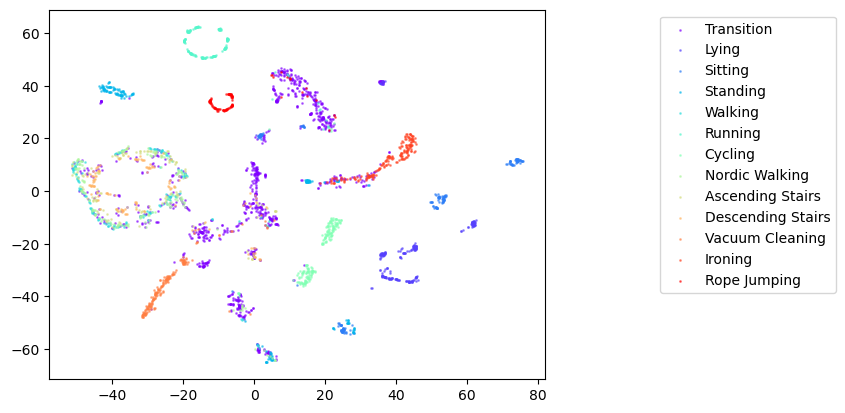

In [55]:
plt.style.use('default')
clustering_output = []
for ts in data_loader:
    recon = deep_cluster_model.AE.encode((ts.float().to(device)))
    clustering_output.append( recon.cpu().detach().numpy() ) 
    

clustering_output = [item for sublist in clustering_output for item in sublist]

clustering_output = np.asarray(clustering_output)
clustering_output_f = []
for i,co in enumerate(clustering_output):
    clustering_output[i].flatten()
    clustering_output_f.append(clustering_output[i].flatten())
clustering_output_f = np.asarray(clustering_output_f)

activities = []
activities.append(labels[0])
for l in labels:
    if l != activities[-1]:
        activities.append(int(l))


activity_names = ['Transition',
                  'Lying',
                  'Sitting',
                  'Standing',
                  'Walking',
                  'Running',
                  'Cycling',
                  'Nordic Walking',
                  '8',
                  'Watching TV',
                  'Computer Work',
                  'Car Driving',
                  'Ascending Stairs',
                  'Descending Stairs',
                  '14',
                  '15',
                  'Vacuum Cleaning',
                  'Ironing',
                  'Folding Laundry',
                  'House Cleaning',
                  'Playing Soccer',
                  '21',
                  '22',
                  '23',
                  'Rope Jumping']

X_embedded = TSNE(n_components=2).fit_transform(clustering_output_f)

cmap = plt.get_cmap('rainbow')

l = np.unique(labels)
slicedCM = cmap(np.linspace(0, 1, len(l))) 



for m,la in enumerate(l): 
    ind = np.where(subsequence_labels==la)
    plt.scatter(X_embedded[ind,0],X_embedded[ind,1],color=slicedCM[m], label=activity_names[int(la)], alpha=0.5, s=1)

plt.legend(loc=1, bbox_to_anchor=(1.1, 0., 0.5, 1.0))

In [11]:
import umap


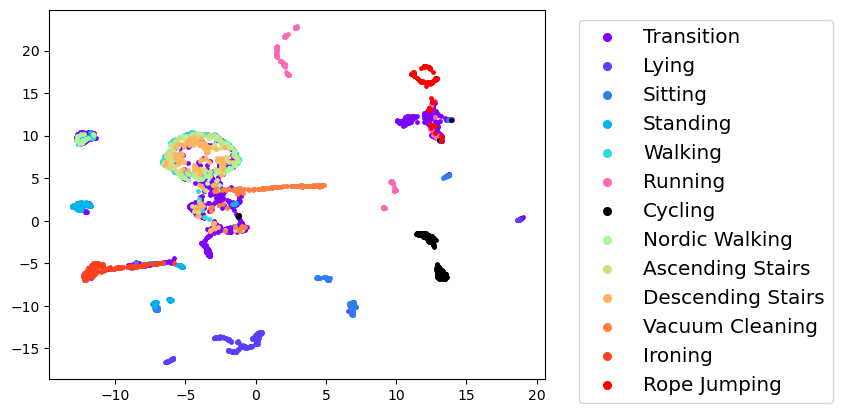

In [28]:
plt.style.use('default')
clustering_output = []
for ts in data_loader:
    recon = deep_cluster_model.AE.encode((ts.float().to(device)))
    clustering_output.append( recon.cpu().detach().numpy() ) 
    

clustering_output = [item for sublist in clustering_output for item in sublist]

clustering_output = np.asarray(clustering_output)
clustering_output_f = []
for i,co in enumerate(clustering_output):
    clustering_output[i].flatten()
    clustering_output_f.append(clustering_output[i].flatten())
clustering_output_f = np.asarray(clustering_output_f)

activities = []
activities.append(labels[0])
for l in labels:
    if l != activities[-1]:
        activities.append(int(l))


activity_names = ['Transition',
                  'Lying',
                  'Sitting',
                  'Standing',
                  'Walking',
                  'Running',
                  'Cycling',
                  'Nordic Walking',
                  '8',
                  'Watching TV',
                  'Computer Work',
                  'Car Driving',
                  'Ascending Stairs',
                  'Descending Stairs',
                  '14',
                  '15',
                  'Vacuum Cleaning',
                  'Ironing',
                  'Folding Laundry',
                  'House Cleaning',
                  'Playing Soccer',
                  '21',
                  '22',
                  '23',
                  'Rope Jumping']

reducer = umap.UMAP(n_neighbors=30, min_dist=0.3)
X_embedded = reducer.fit_transform(clustering_output_f)

cmap = plt.get_cmap('rainbow')

l = np.unique(labels)
slicedCM = cmap(np.linspace(0, 1, len(l))) 



for m,la in enumerate(l): 
    ind = np.where(subsequence_labels==la)
    if m == 6: 
        plt.scatter(X_embedded[ind,0],X_embedded[ind,1],color='k', label=activity_names[int(la)], alpha=1.0, s=6)
    elif m == 5:
        plt.scatter(X_embedded[ind,0],X_embedded[ind,1],color='hotpink', label=activity_names[int(la)], alpha=1.0, s=6)
    else:
        plt.scatter(X_embedded[ind,0],X_embedded[ind,1],color=slicedCM[m], label=activity_names[int(la)], alpha=1.0, s=6)

lgnd = plt.legend(loc=1, bbox_to_anchor=(1.1, 0., 0.5, 1.0),fontsize="x-large")
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]
lgnd.legendHandles[4]._sizes = [30]
lgnd.legendHandles[5]._sizes = [30]
lgnd.legendHandles[6]._sizes = [30]
lgnd.legendHandles[7]._sizes = [30]
lgnd.legendHandles[8]._sizes = [30]
lgnd.legendHandles[9]._sizes = [30]
lgnd.legendHandles[10]._sizes = [30]
lgnd.legendHandles[11]._sizes = [30]
lgnd.legendHandles[12]._sizes = [30]
plt.savefig("umap.png")

In [27]:
clustering_output_f.shape

(2940, 40)

## Remove Duplicate Cluster Labels and Set Labels in Sequential Order

In [38]:
while ( (not all(l[i] == l[i+1] -1 for i in range(len(l) - 1))) or (l[0] != 0) ):
    for assignment in range(np.max(cluster_assignments)+1):
        if assignment not in cluster_assignments:
            indx = np.where(cluster_assignments > assignment)
            cluster_assignments[indx] = cluster_assignments[indx]-1
    l = np.unique(cluster_assignments)

## Phase 3: Sldiing Window on Cluster Labels

In [39]:
window_length2 = 30
similarities = get_label_score(cluster_assignments, window_length2)


## Normalize and Smooth Sliding Window Distance

In [40]:
data = (similarities - np.min(similarities)) / (np.max(similarities) - np.min(similarities))
data = smooth(np.blackman(50), data)

In [41]:
peaks, peak_data = find_peaks(data, height=0.62,distance=window_length2//2,prominence=0.1)
real_peaks = peaks+window_length2//2
predictions = get_changepoints(real_peaks, window_length, overlap_percent)


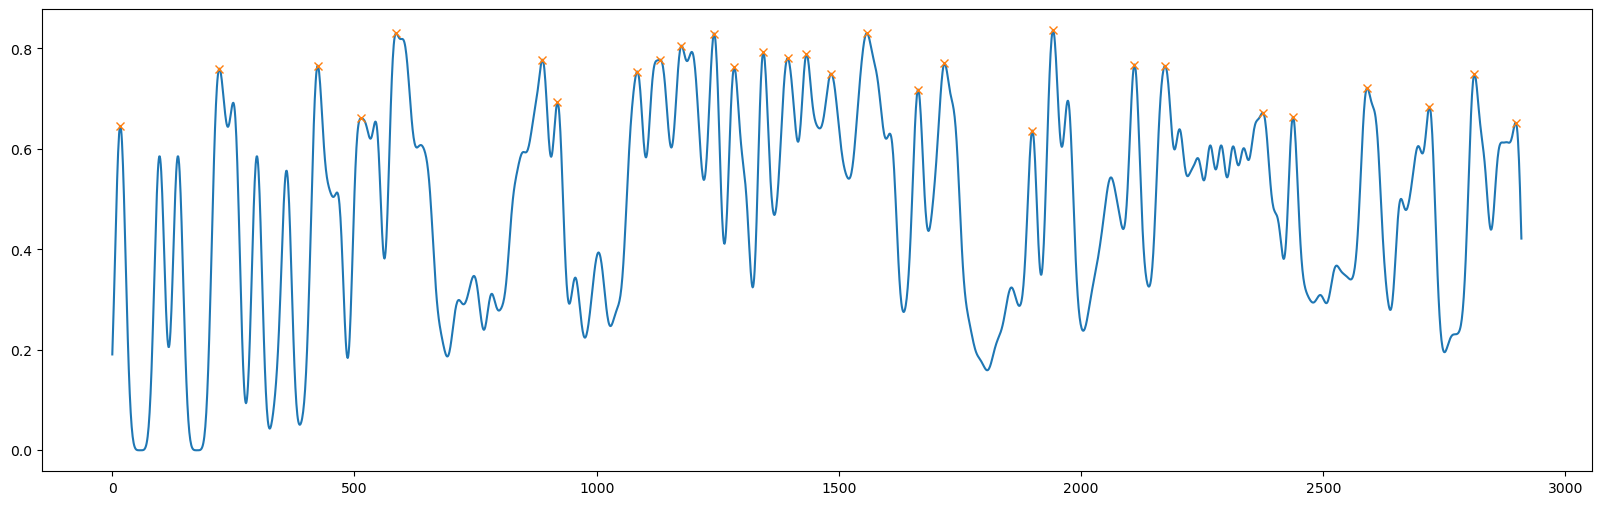

Space: Encoded Hidden Space
Clusters = 100


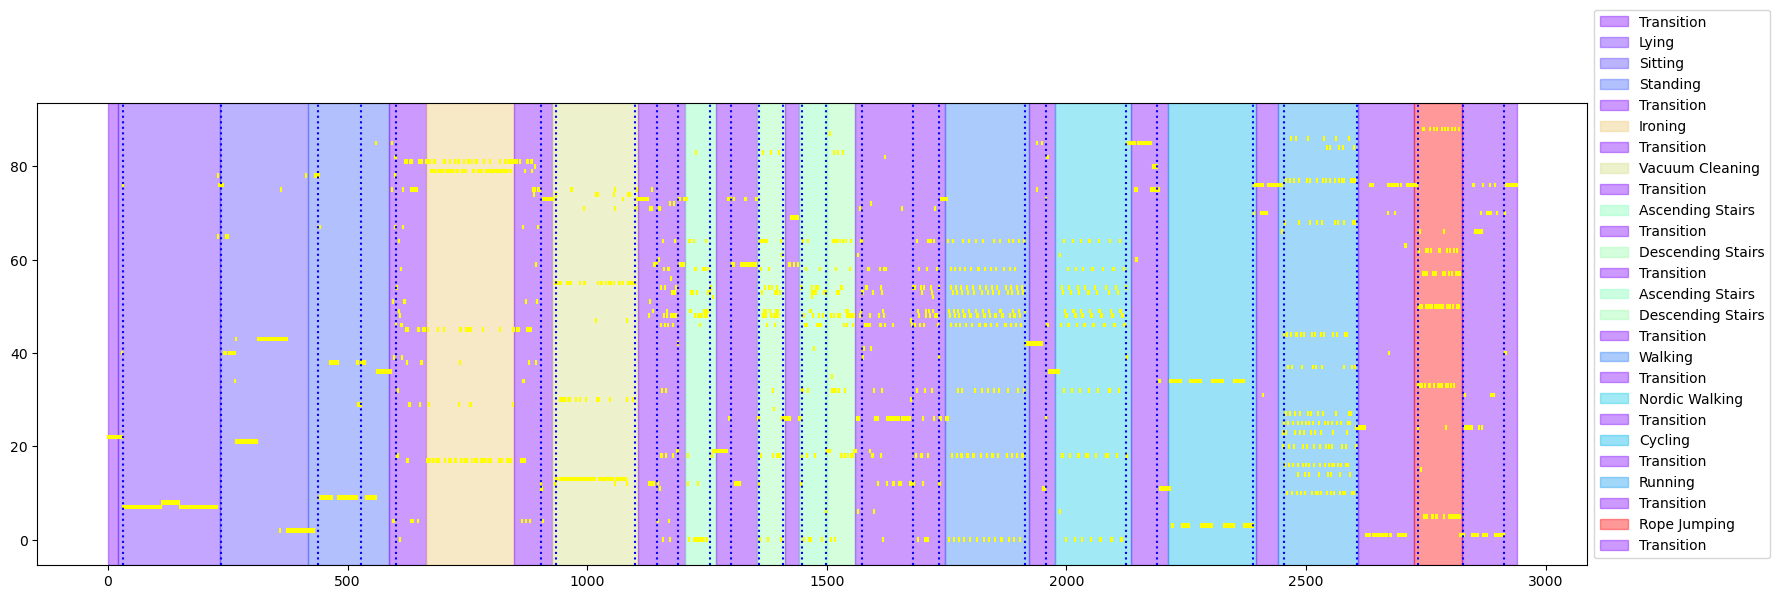

covering score: 0.744810363761587
margin: 3000
f_measure score: (0.8571428571428571, 0.8, 0.9230769230769231)


In [42]:
plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')
cmap = plt.get_cmap('rainbow')

l = np.unique(labels)


slicedCM = cmap(np.linspace(0, 1, len(activity_names))) 


plt.plot(data)
plt.plot(peaks, data[peaks], "x")
plt.show()

positions = np.arange(len(cluster_assignments))[:,np.newaxis]

plt.eventplot(positions, lineoffsets=cluster_assignments, color = [(1.0,1.0,0.0)])

for vline in real_peaks:
    plt.axvline(x = vline, color = 'b', linestyle=':', mfc='b')

start = 0
subsequence_ground_truth = np.where(subsequence_labels[:-1] != subsequence_labels[1:])[0]
print("Space: Encoded Hidden Space\nClusters = {}".format(n_clusters))
for i, activity in enumerate(activities):
    if i == len(activities):
        continue
    if i == len(activities)-1:
        end = len(subsequence_labels)
    else:
        end = subsequence_ground_truth[i]

    plt.axvspan(start, end, alpha=0.4, color=slicedCM[int(activity)], label=activity_names[int(activity)])
    plt.legend(loc=3, bbox_to_anchor=(1, 0, 0, 1.0))
    start = end
plt.show()

print('covering score:',covering(ground_truth, predictions, len(labels)))
margin = 100*30
print('margin:',margin)
print('f_measure score:',f_measure(ground_truth, predictions, margin=margin, alpha=0.5, return_PR=True))